Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


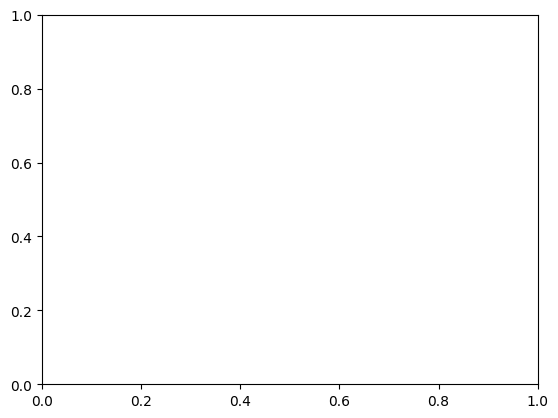

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
plt.grid(False)
%matplotlib inline
import seaborn as sns
sns.set()

from google.colab import drive
drive.mount("/content/gdrive")

In [49]:
df = pd.read_csv('/content/gdrive/MyDrive/solar_irradiation_data.csv')
df = df.dropna(subset = ['GHI_AVG', 'TEMP_AVG', 'HUM_AVG'])
df.describe()

,GHI_AVG,DNI_AVG,WDIR_AVG,WSPD_AVG,TEMP_AVG,HUM_AVG,RAIN_SUM
count,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000,25842.000000
mean,261.468428,305.604844,174.510184,1.388757,21.421420,38.827830,38776.075753
std,350.681499,398.681049,75.716074,4.424704,9.321068,22.312720,103696.380212
min,-6.350522,-4.650700,0.000000,0.000000,-4.173657,4.267947,0.000000
25%,-0.636510,-1.356412,120.185135,0.384553,14.878512,21.659492,0.000000
50%,6.630593,0.000000,161.973918,1.152047,21.852783,33.345202,0.000000
75%,548.069702,767.101214,243.644972,2.155846,28.335655,51.553219,6192.000000
max,1170.911090,1076.749711,700.014391,652.826218,44.854888,99.932081,429120.000000


In [50]:
import random
def create_dataset(X,batch_size,time_steps=1,pred_steps=1):
  Xs,ys = [],[]
  for i in range(batch_size):
    idx = random.randint(0,len(X)-time_steps-pred_steps)
    v = X[idx:idx+time_steps, :]
    u = X[idx+time_steps:idx+time_steps+pred_steps, :]
    Xs.append(v)
    ys.append(u)
  return np.array(Xs), np.array(ys)

In [51]:
from sklearn.preprocessing import MinMaxScaler
def scaler(data):
  scaler = MinMaxScaler(feature_range=(0,1))
  data_use = scaler.fit_transform(data)
  return data_use

In [52]:
df['TIME'] = pd.to_datetime(df['Time'])
df['hour'] = df['TIME'].dt.hour
data_use = scaler(df.iloc[:,[2]])
X = data_use

time_steps = 24*7*4
pred_steps = 24*7*1
X_data, y_data = create_dataset(np.array(X),100,time_steps,pred_steps)

In [53]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
from keras.optimizers import Adam 

# convolutional operation parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)]

# define an input history series and pass it through a stack of dilated causal convolution blocks. 
history_seq = Input(shape=(None, 1))
x = history_seq

skips = []
for dilation_rate in dilation_rates:
    
    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation='relu')(x) 
    
    # filter convolution
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # gating convolution
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='causal',
                 dilation_rate=dilation_rate)(x)
    
    # multiply filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])
    
    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same', activation='relu')(z)
    
    # residual connection
    x = Add()([x, z])    
    
    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

# final time-distributed dense layers 
out = Conv1D(128, 1, padding='same')(out)
out = Activation('relu')(out)
out = Dropout(.2)(out)
out = Conv1D(1, 1, padding='same')(out)

# extract the last 60 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':168})(out)

model = Model(history_seq, pred_seq_train)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d_34 (Conv1D)             (None, None, 16)     32          ['input_2[0][0]']                
                                                                                                  
 conv1d_35 (Conv1D)             (None, None, 32)     1056        ['conv1d_34[0][0]']              
                                                                                                  
 conv1d_36 (Conv1D)             (None, None, 32)     1056        ['conv1d_34[0][0]']              
                                                                                            

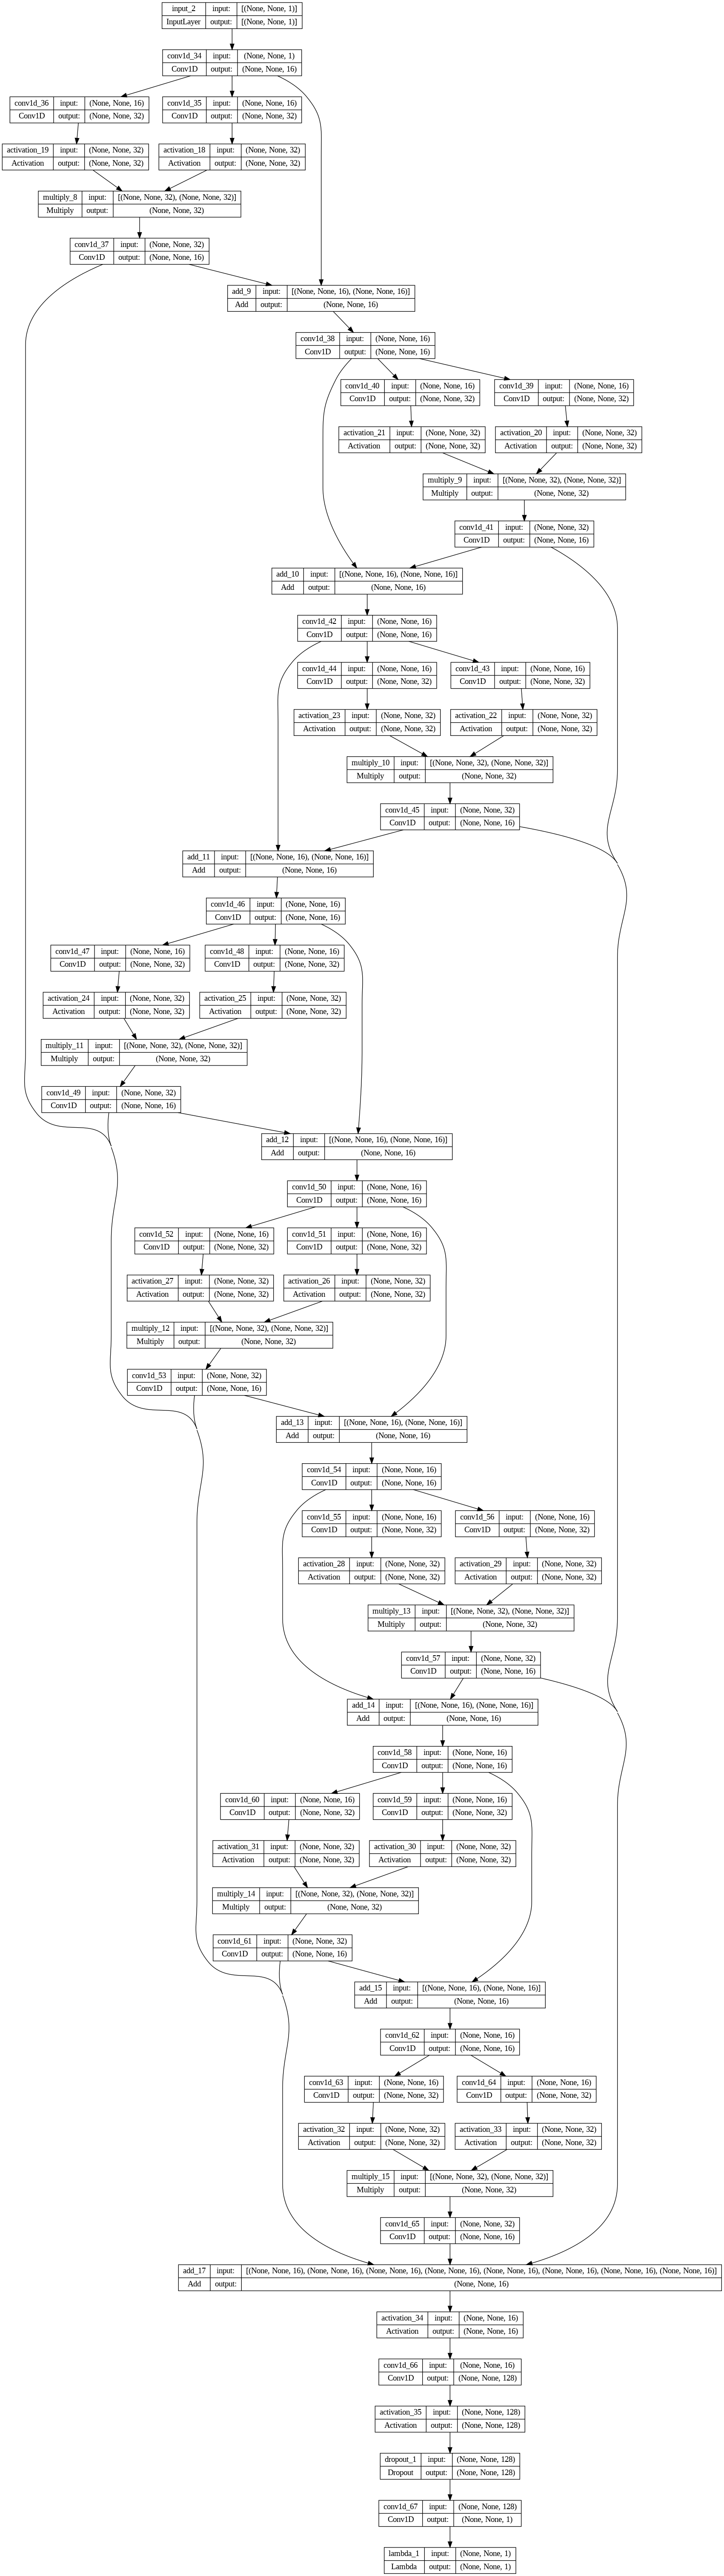

In [55]:
from keras.utils.vis_utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True)


In [78]:
model.compile(Adam(), loss='mean_squared_error')
model.fit(X_data,y_data, batch_size=10, epochs=20,validation_split=0.2)

Epoch 1/20
8/8 [==============================] - 7s 394ms/step - loss: 0.0176 - val_loss: 0.0100
Epoch 2/20
8/8 [==============================] - 1s 171ms/step - loss: 0.0168 - val_loss: 0.0100
Epoch 3/20
8/8 [==============================] - 1s 136ms/step - loss: 0.0170 - val_loss: 0.0099
Epoch 4/20
8/8 [==============================] - 1s 134ms/step - loss: 0.0166 - val_loss: 0.0119
Epoch 5/20
8/8 [==============================] - 1s 136ms/step - loss: 0.0168 - val_loss: 0.0099
Epoch 6/20
8/8 [==============================] - 1s 136ms/step - loss: 0.0167 - val_loss: 0.0108
Epoch 7/20
8/8 [==============================] - 1s 137ms/step - loss: 0.0164 - val_loss: 0.0097
Epoch 8/20
8/8 [==============================] - 1s 135ms/step - loss: 0.0166 - val_loss: 0.0095
Epoch 9/20
8/8 [==============================] - 1s 135ms/step - loss: 0.0173 - val_loss: 0.0094
Epoch 10/20
8/8 [==============================] - 1s 137ms/step - loss: 0.0170 - val_loss: 0.0113
Epoch 11/20
8/8 [==

In [57]:
data = pd.DataFrame(columns = ['epochs','loss','val_loss'])

In [58]:
data['epochs']=[1,
2,
3,
4,
5,
6,
7,
8,
9,
10, 
11,
12,
13,
14,
15,
16,
17,
18,
19,
20]

data['loss'] = [0.0972,
0.0490,
0.0276,
0.0209,
0.0191,
0.0184,
0.0174,
0.0171,
0.0167,
0.0163,
0.0159,
0.0158,
0.0164,
0.0152,
0.0154,
0.0149,
0.0151,
0.0147,
0.0150,
0.0154]

data['val_loss']= [
0.0607,
0.0366,
0.0248,
0.0238,
0.0221,
0.0218,
0.0211,
0.0208,
0.0205,
0.0201,
0.0200,
0.0216,
0.0202,
0.0205,
0.0196,
0.0198,
0.0195,
0.0196,
0.0212,
0.0197]

In [79]:
import random
def create_dataset_test(X,batch_size,time_steps=1,pred_steps=1):
  Xs,ys = [],[]
  for i in range(batch_size):
    idx = len(X)-time_steps-pred_steps-100
    v = X[idx:idx+time_steps, :]
    u = X[idx+time_steps:idx+time_steps+pred_steps, :]
    Xs.append(v)
    ys.append(u)
  return np.array(Xs), np.array(ys)

In [80]:
X_test, y_test = create_dataset_test(np.array(X),1,time_steps,pred_steps)

In [81]:
pred = model.predict(X_test)

1/1 [==============================] - 1s 720ms/step


In [82]:
pred.shape

(1, 168, 1)

<function matplotlib.pyplot.show(close=None, block=None)>

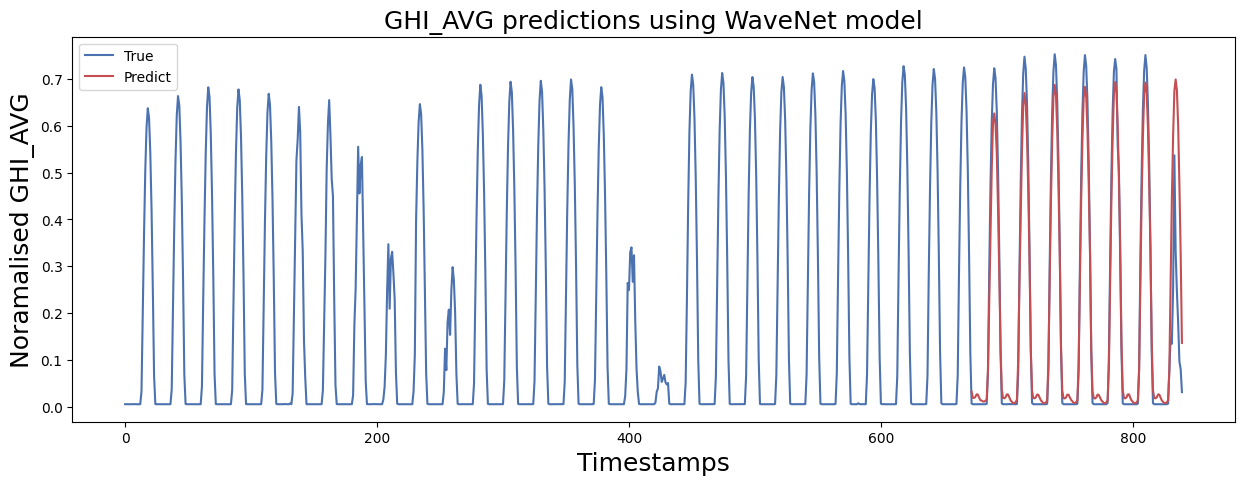

In [83]:
conc = np.concatenate([X_test,y_test],axis=1)
conc = conc.reshape(840,1,1)
conc = conc.reshape(840)
pred = pred.reshape(168,1,1)
pred = pred.reshape(168)

plt.figure(figsize=(15,5))

plt.title('GHI_AVG predictions using WaveNet model',fontsize =18)
#Label for x-axis
plt.xlabel("Timestamps",fontsize =18)
# Label for y-axis
plt.ylabel("Noramalised GHI_AVG",fontsize =18)

plt.plot(range(len(conc)), conc, 'b',label = 'True')
plt.plot(range(672,672+168),pred, 'r',label = 'Predict')
plt.legend()
plt.style.use('default')
plt.grid(False)
plt.savefig('wvnet_1.png',facecolor ='w')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

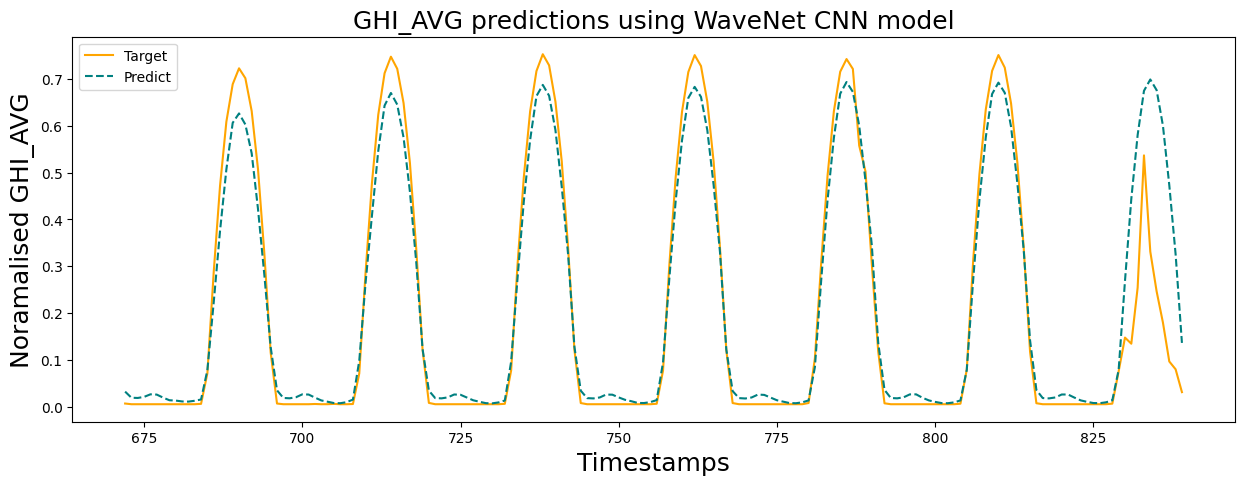

In [84]:
x_encode = time_steps

plt.figure(figsize=(15,5))

plt.title('GHI_AVG predictions using WaveNet CNN model',fontsize =18)
#Label for x-axis
plt.xlabel("Timestamps",fontsize =18)
# Label for y-axis
plt.ylabel("Noramalised GHI_AVG",fontsize =18)

# plt.plot(range(0,x_encode),conc[:-168], label = 'True')
plt.plot(range(x_encode,x_encode+pred_steps),conc[-168:],color='orange',label = 'Target')
plt.plot(range(x_encode,x_encode+pred_steps),pred,color='teal',linestyle='--',label = 'Predict')
plt.legend()
plt.style.use('default')
plt.grid(False)
plt.savefig('wvnet_1.png',facecolor ='w')
plt.show

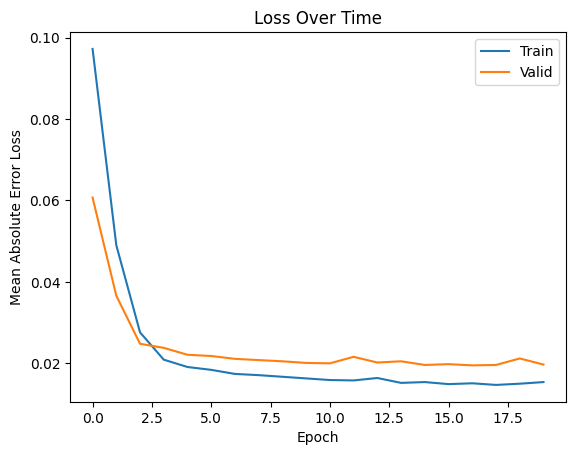

In [85]:
plt.plot(data['loss'])
plt.plot(data['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss') #?!
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

# Performance Metrics

In [86]:
from sklearn.metrics import r2_score
print(r2_score(conc[-168:],pred))


0.9049187234887965


In [87]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE 
print(sqrt(mean_squared_error(conc[-168:],pred)))

0.08315090605754091


In [88]:
from sklearn.metrics import mean_absolute_error

# calculate MAE
print(mean_absolute_error(conc[-168:],pred))

0.04233522991587671


In [89]:
from sklearn.metrics import mean_absolute_percentage_error

# calculate MAPE/MAPD(mean absolute precentaeg deviation)

print(mean_absolute_percentage_error(conc[-168:],pred))

1.2913082653088044


# Save Settings

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
model.save('wvnet_model.h5')

In [ ]:
# to run the model again, continue frm the point left off
# Restore the weights
# model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
type(X_test)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/My Drive/array.txt', 'w') as f:
    np.savetxt(f, X_test)